In [6]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import talib
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib  # For saving the model
import xgboost as xgb
from sklearn.preprocessing import StandardScaler  # ← Thêm dòng này


In [7]:
class CryptoTradingBot:
    def __init__(self, csv_file_path, short_ema=9, long_ema=20, rsi_period=15, 
                 rsi_oversold=30, rsi_overbought=70, initial_balance=10000):
        self.csv_file_path = csv_file_path
        self.short_ema = short_ema
        self.long_ema = long_ema
        self.rsi_period = rsi_period
        self.rsi_oversold = rsi_oversold
        self.rsi_overbought = rsi_overbought
        self.initial_balance = initial_balance
        self.balance = initial_balance
        self.position = 0
        self.trades = []

    def fetch_data(self):
        """Load price data from CSV file"""
        print(f"Loading data from {self.csv_file_path}...")
        
        df = pd.read_csv(self.csv_file_path)
        df['time'] = pd.to_datetime(df['time'])
        df.set_index('time', inplace=True)
        
        # Ensure columns are in correct order and type
        df = df[['open', 'high', 'low', 'close', 'volume']]
        df = df.astype(float)
        
        print(f"Loaded {len(df)} rows from {df.index[0]} to {df.index[-1]}")
        return df

    def calculate_indicators(self, df):
        """Calculate technical indicators: RSI and EMA"""
        df['rsi'] = talib.RSI(df['close'], timeperiod=self.rsi_period)
        df['short_ema'] = df['close'].ewm(span=self.short_ema, adjust=False).mean()
        df['long_ema'] = df['close'].ewm(span=self.long_ema, adjust=False).mean()
        
        df['ema_cross'] = 0
        df.loc[df['short_ema'] > df['long_ema'], 'ema_cross'] = 1
        df.loc[df['short_ema'] < df['long_ema'], 'ema_cross'] = -1
        
        df['signal'] = 0
        
        buy_condition = ((df['rsi'] < self.rsi_oversold) | 
                        ((df['short_ema'] > df['long_ema']) & (df['short_ema'].shift(1) <= df['long_ema'].shift(1))))
        
        sell_condition = ((df['rsi'] > self.rsi_overbought) | 
                        ((df['short_ema'] < df['long_ema']) & (df['short_ema'].shift(1) >= df['long_ema'].shift(1))))
        
        df.loc[buy_condition, 'signal'] = 1
        df.loc[sell_condition, 'signal'] = -1
        
        return df

    def backtest(self, data):
        """Perform backtest based on data and strategy"""
        df = data.copy()
        
        balance = self.initial_balance
        position = 0
        entry_price = 0
        trades = []
        
        for i, row in df.iterrows():
            if np.isnan(row['rsi']) or np.isnan(row['short_ema']) or np.isnan(row['long_ema']):
                continue
            
            if row['signal'] == 1 and position == 0:
                position = balance / row['close']
                entry_price = row['close']
                trades.append({
                    'date': i,
                    'type': 'buy',
                    'price': row['close'],
                    'position': position,
                    'balance': balance,
                    'rsi': row['rsi'],
                    'short_ema': row['short_ema'],
                    'long_ema': row['long_ema']
                })
                balance = 0
            
            elif row['signal'] == -1 and position > 0:
                balance = position * row['close']
                profit_pct = (row['close'] - entry_price) / entry_price * 100
                trades.append({
                    'date': i,
                    'type': 'sell',
                    'price': row['close'],
                    'position': position,
                    'balance': balance,
                    'profit_pct': profit_pct,
                    'rsi': row['rsi'],
                    'short_ema': row['short_ema'],
                    'long_ema': row['long_ema']
                })
                position = 0
        
        if position > 0:
            balance = position * df.iloc[-1]['close']
            profit_pct = (df.iloc[-1]['close'] - entry_price) / entry_price * 100
            trades.append({
                'date': df.index[-1],
                'type': 'sell',
                'price': df.iloc[-1]['close'],
                'position': position,
                'balance': balance,
                'profit_pct': profit_pct,
                'rsi': df.iloc[-1]['rsi'],
                'short_ema': df.iloc[-1]['short_ema'],
                'long_ema': df.iloc[-1]['long_ema']
            })
        
        return trades, balance

    def evaluate_performance(self, trades, final_balance):
        """Evaluate the performance of the strategy"""
        if not trades:
            return {
                'total_trades': 0,
                'win_rate': 0,
                'profit_pct': 0,
                'max_drawdown': 0
            }
        
        profitable_trades = [t for t in trades if t['type'] == 'sell' and t.get('profit_pct', 0) > 0]
        win_rate = len(profitable_trades) / len([t for t in trades if t['type'] == 'sell']) * 100
        
        profit_pct = (final_balance - self.initial_balance) / self.initial_balance * 100
        
        max_balance = self.initial_balance
        max_drawdown = 0
        
        for trade in trades:
            if trade['type'] == 'sell':
                if trade['balance'] > max_balance:
                    max_balance = trade['balance']
                
                drawdown = (max_balance - trade['balance']) / max_balance * 100
                if drawdown > max_drawdown:
                    max_drawdown = drawdown
        
        return {
            'total_trades': len([t for t in trades if t['type'] == 'sell']),
            'win_rate': win_rate,
            'profit_pct': profit_pct,
            'max_drawdown': max_drawdown
        }

    def plot_results(self, df, trades):
        """Plot the results"""
        plt.figure(figsize=(14, 10))
        
        plt.subplot(3, 1, 1)
        plt.plot(df.index, df['close'], label='Close Price')
        plt.plot(df.index, df['short_ema'], label=f'EMA {self.short_ema}')
        plt.plot(df.index, df['long_ema'], label=f'EMA {self.long_ema}')
        
        buy_trades = [t for t in trades if t['type'] == 'buy']
        sell_trades = [t for t in trades if t['type'] == 'sell']
        
        plt.scatter([t['date'] for t in buy_trades], [t['price'] for t in buy_trades], 
                    marker='^', color='g', s=100, label='Buy')
        plt.scatter([t['date'] for t in sell_trades], [t['price'] for t in sell_trades], 
                    marker='v', color='r', s=100, label='Sell')
        
        plt.title('Price Chart and Trading Signals')
        plt.legend()
        
        plt.subplot(3, 1, 2)
        plt.plot(df.index, df['rsi'], label='RSI')
        plt.axhline(y=self.rsi_oversold, color='g', linestyle='-', label=f'RSI Oversold ({self.rsi_oversold})')
        plt.axhline(y=self.rsi_overbought, color='r', linestyle='-', label=f'RSI Overbought ({self.rsi_overbought})')
        plt.title('RSI')
        plt.legend()
        
        plt.subplot(3, 1, 3)
        cumulative_returns = []
        balance = self.initial_balance
        
        for i, row in df.iterrows():
            for trade in trades:
                if trade['date'] == i:
                    if trade['type'] == 'sell':
                        balance = trade['balance']
            cumulative_returns.append(balance)
        
        plt.plot(df.index, cumulative_returns, label='Cumulative Returns')
        plt.title('Cumulative Returns')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

    def run(self):
        """Run the entire process"""
        # Fetch data
        df = self.fetch_data()
        
        # Calculate indicators
        df = self.calculate_indicators(df)
        
        # Perform backtest
        trades, final_balance = self.backtest(df)
        
        # Evaluate performance
        performance = self.evaluate_performance(trades, final_balance)
        
        # Print results
        print("\n===== BACKTEST RESULTS =====")
        print(f"Total Trades: {performance['total_trades']}")
        print(f"Win Rate: {performance['win_rate']:.2f}%")
        print(f"Profit: {performance['profit_pct']:.2f}%")
        print(f"Max Drawdown: {performance['max_drawdown']:.2f}%")
        print(f"Initial Balance: ${self.initial_balance:.2f}")
        print(f"Final Balance: ${final_balance:.2f}")
        
        # Plot results
        self.plot_results(df, trades)
        
        return df, trades, performance

In [8]:
class XboostCryptoTradingBot:
    def __init__(self, csv_file_path, short_ema=9, long_ema=21, rsi_period=14, 
                 rsi_oversold=30, rsi_overbought=70, initial_balance=10000):
        self.csv_file_path = csv_file_path
        self.short_ema = short_ema
        self.long_ema = long_ema
        self.rsi_period = rsi_period
        self.rsi_oversold = rsi_oversold
        self.rsi_overbought = rsi_overbought
        self.initial_balance = initial_balance
        self.balance = initial_balance
        self.position = 0
        self.trades = []
        self.model = None
        self.scaler = StandardScaler()

    def fetch_data(self):
        """Load price data from CSV file"""
        print(f"Loading data from {self.csv_file_path}...")
        
        df = pd.read_csv(self.csv_file_path)
        df['time'] = pd.to_datetime(df['time'])
        df.set_index('time', inplace=True)
        
        # Ensure columns are in correct order and type
        df = df[['open', 'high', 'low', 'close', 'volume']]
        df = df.astype(float)
        
        print(f"Loaded {len(df)} rows from {df.index[0]} to {df.index[-1]}")
        return df

    def calculate_indicators(self, df):
        """Calculate technical indicators: RSI and EMA"""
        df['rsi'] = talib.RSI(df['close'], timeperiod=self.rsi_period)
        df['short_ema'] = df['close'].ewm(span=self.short_ema, adjust=False).mean()
        df['long_ema'] = df['close'].ewm(span=self.long_ema, adjust=False).mean()
        
        df.dropna(inplace=True)
        return df

    def prepare_features(self, df):
        """Prepare enhanced features for the XGBoost model"""
        # Existing features
        df['price_change'] = df['close'].pct_change() * 100
        df['volatility'] = df['close'].rolling(window=14).std()
        df['ema_diff'] = df['short_ema'] - df['long_ema']
        df['ema_diff_pct'] = df['ema_diff'] / df['close'] * 100
        
        # New features
        df['macd'], df['macd_signal'], df['macd_hist'] = talib.MACD(df['close'])
        df['upper_band'], df['middle_band'], df['lower_band'] = talib.BBANDS(df['close'])
        df['bb_width'] = (df['upper_band'] - df['lower_band']) / df['middle_band']
        df['atr'] = talib.ATR(df['high'], df['low'], df['close'], timeperiod=14)
        df['adx'] = talib.ADX(df['high'], df['low'], df['close'])
        
        # Timeframe-based features
        for period in [3, 7, 14]:
            df[f'return_{period}d'] = df['close'].pct_change(period) * 100
            df[f'volume_change_{period}d'] = df['volume'].pct_change(period) * 100
        
        # Target variable
        df['future_return'] = df['close'].shift(-24) / df['close'] - 1
        df['target'] = pd.qcut(df['future_return'], 3, labels=[0, 1, 2])
        
        df.dropna(inplace=True)
        
        features = ['rsi', 'price_change', 'volatility', 'ema_diff', 'ema_diff_pct', 
                    'macd', 'macd_signal', 'macd_hist', 'bb_width', 'atr', 'adx']
        for period in [3, 7, 14]:
            features.append(f'return_{period}d')
            features.append(f'volume_change_{period}d')
        
        return df, features

    def train_model(self, df):
        """Train the XGBoost model with hyperparameter tuning"""
        df, features = self.prepare_features(df)
        
        X = df[features]
        y = df['target']
        
        # Normalize the features
        X = self.scaler.fit_transform(X)
        
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Train the XGBoost model
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test, label=y_test)
        
        params = {
            'objective': 'multi:softprob',
            'num_class': 3,
            'max_depth': 5,
            'eta': 0.05,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'min_child_weight': 1,
            'gamma': 0.1,
            'eval_metric': 'mlogloss'
        }
        
        evallist = [(dtrain, 'train'), (dtest, 'eval')]
        self.model = xgb.train(params, dtrain, num_boost_round=100, 
                            evals=evallist, early_stopping_rounds=50)
        
        # Evaluate the model
        preds = self.model.predict(dtest)
        preds_class = np.argmax(preds, axis=1)
        print(classification_report(y_test, preds_class))

    def predict_signal(self, current_data):
        """Predict trading signal using the trained model"""
        if self.model is None:
            print("Model needs to be trained before prediction!")
            return 0
        
        dcurrent = xgb.DMatrix(current_data)
        prediction = self.model.predict(dcurrent)
        
        pred_class = np.argmax(prediction, axis=1)[0]
        pred_proba = prediction[0, pred_class]
        
        confidence_threshold = 0.6
        
        if pred_class == 2 and pred_proba > confidence_threshold:
            return 1
        elif pred_class == 0 and pred_proba > confidence_threshold:
            return -1
        else:
            return 0

    def backtest(self, data):
        """Perform backtest based on predictions from the XGBoost model"""
        df = data.copy()
        df = self.calculate_indicators(df)
        df, features = self.prepare_features(df)
        
        balance = self.initial_balance
        position = 0
        entry_price = 0
        trades = []
        
        for i in range(len(df)):
            current_row = df.iloc[i]
            
            if i < 24:
                continue
            
            current_data = df.iloc[i:i+1][features]
            
            if current_data.isna().any().any():
                continue
                
            signal = self.predict_signal(self.scaler.transform(current_data))
            
            if signal == 1 and position == 0:
                position = balance / current_row['close']
                entry_price = current_row['close']
                trades.append({
                    'date': current_row.name,
                    'type': 'buy',
                    'price': current_row['close'],
                    'position': position,
                    'balance': balance
                })
                balance = 0
            
            elif signal == -1 and position > 0:
                balance = position * current_row['close']
                profit_pct = (current_row['close'] - entry_price) / entry_price * 100
                trades.append({
                    'date': current_row.name,
                    'type': 'sell',
                    'price': current_row['close'],
                    'position': position,
                    'balance': balance,
                    'profit_pct': profit_pct
                })
                position = 0
        
        if position > 0:
            balance = position * df.iloc[-1]['close']
            trades.append({
                'date': df.index[-1],
                'type': 'sell',
                'price': df.iloc[-1]['close'],
                'position': position,
                'balance': balance
            })
        
        return trades, balance

    def evaluate_performance(self, trades, final_balance):
        """Evaluate the performance of the strategy"""
        if not trades:
            return {
                'total_trades': 0,
                'win_rate': 0,
                'profit_pct': 0,
                'max_drawdown': 0
            }
        
        profitable_trades = [t for t in trades if t['type'] == 'sell' and t.get('profit_pct', 0) > 0]
        win_rate = len(profitable_trades) / len([t for t in trades if t['type'] == 'sell']) * 100
        
        profit_pct = (final_balance - self.initial_balance) / self.initial_balance * 100
        
        return {
            'total_trades': len([t for t in trades if t['type'] == 'sell']),
            'win_rate': win_rate,
            'profit_pct': profit_pct
        }

    def plot_results(self, df, trades):
        """Plot the results"""
        plt.figure(figsize=(14, 10))
        
        plt.subplot(3, 1, 1)
        plt.plot(df.index, df['close'], label='Close Price')
        
        buy_trades = [t for t in trades if t['type'] == 'buy']
        sell_trades = [t for t in trades if t['type'] == 'sell']
        
        plt.scatter([t['date'] for t in buy_trades], [t['price'] for t in buy_trades], 
                    marker='^', color='g', s=100, label='Buy')
        plt.scatter([t['date'] for t in sell_trades], [t['price'] for t in sell_trades], 
                    marker='v', color='r', s=100, label='Sell')
        
        plt.title('Price Chart and Trading Signals')
        plt.legend()
        
        plt.subplot(3, 1, 2)
        plt.plot(df.index, df['rsi'], label='RSI')
        plt.axhline(y=self.rsi_oversold, color='g', linestyle='-', label='RSI Oversold (30)')
        plt.axhline(y=self.rsi_overbought, color='r', linestyle='-', label='RSI Overbought (70)')
        plt.title('RSI')
        plt.legend()
        
        plt.subplot(3, 1, 3)
        cumulative_returns = []
        balance = self.initial_balance
        
        for i, row in df.iterrows():
            for trade in trades:
                if trade['date'] == i:
                    if trade['type'] == 'sell':
                        balance = trade['balance']
            cumulative_returns.append(balance)
        
        plt.plot(df.index, cumulative_returns, label='Cumulative Returns')
        plt.title('Cumulative Returns')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

    def run(self):
        """Run the entire process"""
        df = self.fetch_data()
        df = self.calculate_indicators(df)
        self.train_model(df)
        trades, final_balance = self.backtest(df)
        performance = self.evaluate_performance(trades, final_balance)
        
        print("\n===== BACKTEST RESULTS =====")
        print(f"Total Trades: {performance['total_trades']}")
        print(f"Win Rate: {performance['win_rate']:.2f}%")
        print(f"Profit: {performance['profit_pct']:.2f}%")
        print(f"Initial Balance: ${self.initial_balance:.2f}")
        print(f"Final Balance: ${final_balance:.2f}")
        
        self.plot_results(df, trades)
        
        return df, trades, performance

In [9]:
import matplotlib.pyplot as plt

def plot_ml_results(self, df, trades):
    """Plot results of the ML backtest."""
    plt.figure(figsize=(14, 12))
    
    # Plot Close Price and Trading Signals
    plt.subplot(4, 1, 1)
    plt.plot(df.index[-100:], df['close'][-100:], label='Close Price', color='blue', linewidth=2)
    
    buy_trades = [t for t in trades if t['type'] == 'buy']
    sell_trades = [t for t in trades if t['type'] == 'sell']
    
    plt.scatter([t['date'] for t in buy_trades], [t['price'] for t in buy_trades], 
                marker='^', color='green', s=100, label='Buy Signal', alpha=0.7)
    plt.scatter([t['date'] for t in sell_trades], [t['price'] for t in sell_trades], 
                marker='v', color='red', s=100, label='Sell Signal', alpha=0.7)
    
    plt.title('Price Chart and ML Trading Signals', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price', fontsize=12)
    plt.legend()
    plt.grid()

    # Plot Prediction Probability
    plt.subplot(4, 1, 2)
    probabilities = [t['probability'] for t in trades if 'probability' in t]
    dates = [t['date'] for t in trades if 'probability' in t]
    
    plt.scatter(dates, probabilities, 
                color='green', s=80, label='Prediction Probability', alpha=0.5)
    
    plt.axhline(y=0.7, color='black', linestyle='--', label='Probability Threshold (0.7)')
    plt.title('Prediction Probability', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Probability', fontsize=12)
    plt.ylim(0, 1)  # Set y-axis limits for probabilities
    plt.legend()
    plt.grid()

    # Plot RSI
    plt.subplot(4, 1, 3)
    plt.plot(df.index[-100:], df['rsi'][-100:], label='RSI', color='purple', linewidth=2)
    plt.axhline(y=70, color='red', linestyle='--', label='Overbought (70)')
    plt.axhline(y=30, color='green', linestyle='--', label='Oversold (30)')
    
    plt.title('Relative Strength Index (RSI)', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('RSI', fontsize=12)
    plt.legend()
    plt.grid()

    # Plot Cumulative Returns
    plt.subplot(4, 1, 4)
    cumulative_returns = []
    balance = self.initial_balance
    
    for i, row in df.iloc[-100:].iterrows():
        for trade in trades:
            if trade['date'] == i:
                if trade['type'] == 'sell':
                    balance = trade['balance']
        cumulative_returns.append(balance)
    
    plt.plot(df.index[-100:], cumulative_returns, label='Cumulative Returns', color='orange', linewidth=2)
    plt.title('Cumulative Returns', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Balance', fontsize=12)
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

INFO:root:===== RUNNING STANDARD TRADING BOT =====


Loading data from C:\Users\mduc1\OneDrive\Desktop\data\hourly\ACB_hourly_2023-01-01_2025-09-07.csv...
Loaded 2139 rows from 2023-09-11 10:00:00 to 2025-09-05 14:00:00

===== BACKTEST RESULTS =====
Total Trades: 44
Win Rate: 52.27%
Profit: 34.85%
Max Drawdown: 8.53%
Initial Balance: $10000.00
Final Balance: $13484.54


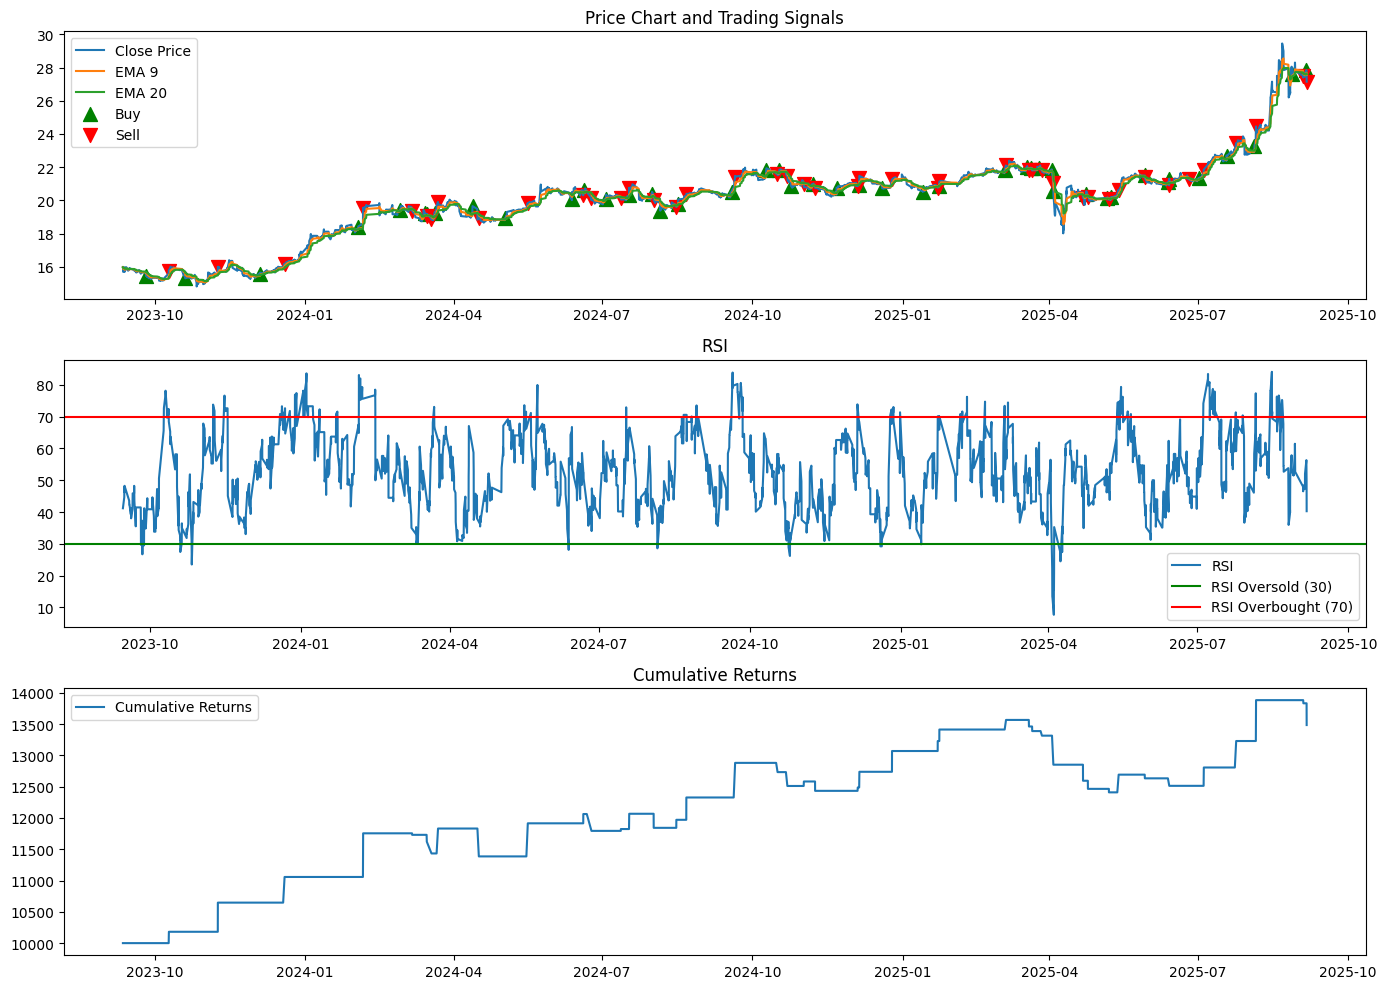

INFO:root:
===== RUNNING ML TRADING BOT =====


Loading data from C:\Users\mduc1\OneDrive\Desktop\data\hourly\ACB_hourly_2023-01-01_2025-09-07.csv...
Loaded 2139 rows from 2023-09-11 10:00:00 to 2025-09-05 14:00:00
[0]	train-mlogloss:1.08694	eval-mlogloss:1.09377
[1]	train-mlogloss:1.07369	eval-mlogloss:1.08610
[2]	train-mlogloss:1.06049	eval-mlogloss:1.07907
[3]	train-mlogloss:1.05000	eval-mlogloss:1.07253
[4]	train-mlogloss:1.03787	eval-mlogloss:1.06520
[5]	train-mlogloss:1.02842	eval-mlogloss:1.06197
[6]	train-mlogloss:1.02097	eval-mlogloss:1.05848
[7]	train-mlogloss:1.01175	eval-mlogloss:1.05458
[8]	train-mlogloss:0.99921	eval-mlogloss:1.04620
[9]	train-mlogloss:0.98790	eval-mlogloss:1.04073
[10]	train-mlogloss:0.97941	eval-mlogloss:1.03791
[11]	train-mlogloss:0.97076	eval-mlogloss:1.03406
[12]	train-mlogloss:0.96092	eval-mlogloss:1.02938
[13]	train-mlogloss:0.95086	eval-mlogloss:1.02337
[14]	train-mlogloss:0.94081	eval-mlogloss:1.01854
[15]	train-mlogloss:0.93107	eval-mlogloss:1.01351
[16]	train-mlogloss:0.92089	eval-mlogloss:1

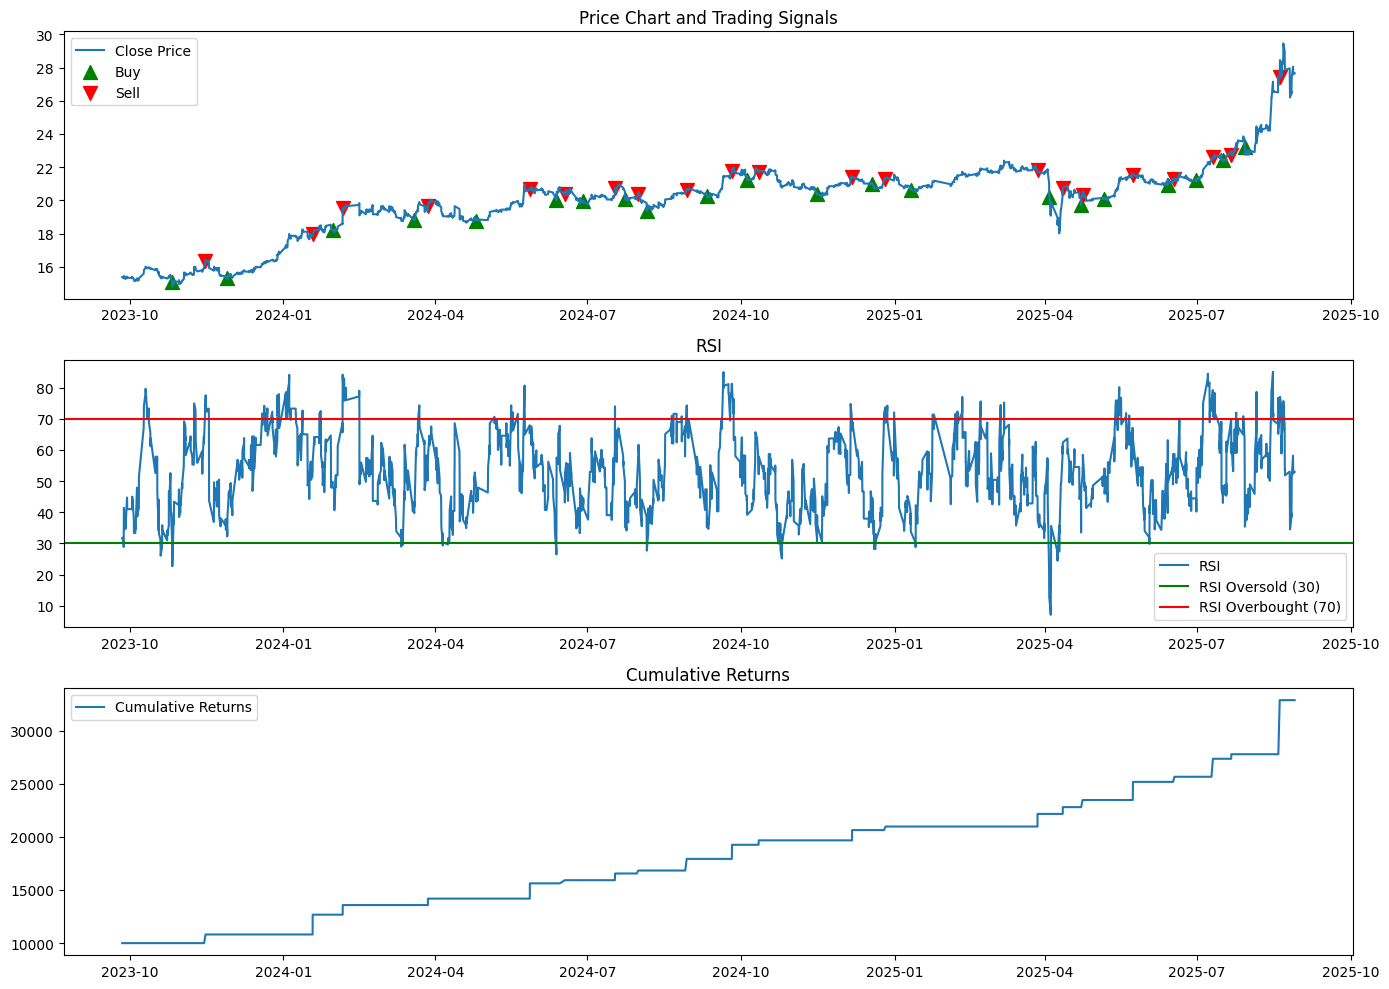

INFO:root:
===== PERFORMANCE COMPARISON =====
INFO:root:Standard Bot - Profit: 34.85%, Win Rate: 52.27%
INFO:root:XGBoost Bot - Profit: 228.64%, Win Rate: 100.00%


In [10]:
import logging
# Set up logging
logging.basicConfig(level=logging.INFO)
csv_file = r"C:\Users\mduc1\OneDrive\Desktop\data\hourly\ACB_hourly_2023-01-01_2025-09-07.csv"
# Run Standard Trading Bot
logging.info("===== RUNNING STANDARD TRADING BOT =====")
bot = CryptoTradingBot(csv_file_path=csv_file, initial_balance=10000)
df, trades, performance = bot.run()
# Run XGBoost Trading Bot
logging.info("\n===== RUNNING ML TRADING BOT =====")
ml_bot = XboostCryptoTradingBot(csv_file_path=csv_file, initial_balance=10000)
ml_df, ml_trades, ml_performance = ml_bot.run()
# Compare results
logging.info("\n===== PERFORMANCE COMPARISON =====")
logging.info(f"Standard Bot - Profit: {performance['profit_pct']:.2f}%, Win Rate: {performance['win_rate']:.2f}%")
logging.info(f"XGBoost Bot - Profit: {ml_performance['profit_pct']:.2f}%, Win Rate: {ml_performance['win_rate']:.2f}%")